K-Means Clustering on Credit Card Dataset - Clustering

Importing the required dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Creating Functions
1-LoadData
2-CleanFun
3-KYFS
4-FTRsclt
5-PCAViz
6-ClusterFun
7-VizFun

1. LoadData

In [2]:
import chardet
import pandas as pd

def import_dataset(Loc):
    # Read the raw data to detect encoding
    rawdata = open(Loc, 'rb').read()
    result = chardet.detect(rawdata)

    # Read the CSV file using the detected encoding
    data = pd.read_csv(Loc, encoding=result['encoding'])

    return data



2. CleanFun

In [3]:

def list_columns_with_missing_values(df):
    result=df.isnull().sum(0)
    return result


def drop_null(df): #This function will clean the dataset by dropping null values.
    df.dropna(inplace=True)
    return(df)

def fill_null_mean(df):

    df_float = df.select_dtypes(include='float64').columns.tolist()
    # Make a copy of float columns
    X = df[df_float].copy()

    # Calculate means of each column
    means = X.mean()

    # Fill missing values with mean values
    X.fillna(value=means, inplace=True)

    # Assign the filled float columns back to the original DataFrame
    df[df_float] = X

    return df


# Usage:
# df = fill_null_mean(df)


def fill_null_median(df): #This function will clean the dataset by dropping null values.
    median=df.median()
    df.fillna(value=median, inplace=True)  # Fill missing values with mean values
    return(df)


def fill_null_knn(df):

    columns_with_missing_values = df.columns[df.isnull().any()].tolist()
    # extract the data from the selected columns
    X = df[columns_with_missing_values].values

    # create a KNN imputer object with k
    imputer = KNNImputer(n_neighbors=2)

    # impute the missing values using KNN imputation
    X_imputed = imputer.fit_transform(X)

    # replace the original columns with the imputed columns
    df[columns_with_missing_values] = X_imputed

    return(df)

def fill_null_knn(df):
# Assuming df is your dataframe
    imputer = KNNImputer()
    imputed_data = imputer.fit_transform(df)

    # Replace original dataframe with imputed data
    df = pd.DataFrame(imputed_data, columns=df.columns)
    return df
# Use below function after converting categorical variable to dummy variable.

def filter_fill_replace(df, threshold, fill_technique='mean'):
    # Step 1: Filter DataFrame based on number of missing values
    columns_with_missing_values = df.columns[df.isnull().any()]
    filtered_df = df[columns_with_missing_values[df[columns_with_missing_values].isnull().sum() > threshold]]

    # Step 2: Fill missing values using specified technique
    for column in filtered_df.columns:

        if fill_technique == 'mean':
            fill_value = filtered_df[column].mean()
        elif fill_technique == 'median':
            fill_value = filtered_df[column].median()
        elif fill_technique == 'mode':
            fill_value = filtered_df[column].mode().iloc[0]  # Use mode for categorical data
        elif fill_technique == 'knn':
            filled_df = fill_null_knn(filtered_df)
            df[filtered_df.columns] = filled_df
            return df
        else:
            raise ValueError("Invalid fill technique. Supported techniques: 'mean', 'median', 'mode', 'knn'")

        filtered_df[column].fillna(fill_value, inplace=True)

    # Step 3: Replace filled columns back into the original DataFrame
    df[filtered_df.columns] = filtered_df

    return df

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd

def impute_missing_mice(df, max_iter=10, random_state=None):

    # Initialize MICE imputer
    imputer = IterativeImputer(max_iter=max_iter, random_state=random_state)

    # Fit and transform the data
    imputed_df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    return imputed_df


def dealing_with_duplicates(df): #This function will clean the dataset.
    print("Number of duplicate rows in your data set:",df.duplicated().sum())
    print("All the duplicate rows have been deleted from data set")

    df.drop_duplicates(inplace=True)
    return(df)




In [33]:

def z_score_normalize_n(df):# Apply z-score normalization to specified numerical features but use with precaution if required
    Numeric_features=df.select_dtypes(include='float64').columns
    for feature in Numeric_features:
        df[feature] = zscore(df[feature])
    return df
def z_score_normalize_i(df):# Apply z-score normalization to specified numerical features but use with precaution if required
    Numeric_features=df.select_dtypes(include='int64').columns
    for feature in Numeric_features:
        df[feature] = zscore(df[feature])
    return df




3. KYFS

In [4]:
def description_dataset(df):

    desc = pd.DataFrame(index = list(df))
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['%unique'] = desc['nunique'] / len(df) * 100
    desc['null'] = df.isnull().sum()
    desc['%null'] = desc['null'] / len(df) * 100
    desc['min'] = df.min()
    desc['max'] = df.max()
    return desc

4. FTRsclt

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def eda(df, hist_color='MAROON', boxplot_color='MAROON'):
    # Separating numerical and categorical features
    numeric_features = df.select_dtypes(include=['float64', 'int64'])
    categorical_features = df.select_dtypes(include=['object'])

    # Summary statistics
    summary_stats = numeric_features.describe().style.set_properties(**{'color': 'maroon', 'text-align': 'center', 'font-weight': 'bold'})
    print("\n\033[1m\033[91mSummary Statistics:\033[0m")
    display(summary_stats)

    num_cols = len(numeric_features.columns)
    num_rows = (num_cols - 1) // 3 + 1  # Calculate number of rows needed

    # Histograms and Box plots
    fig, axes = plt.subplots(nrows=num_rows*2, ncols=3, figsize=(16, 5*num_rows))

    for i, column in enumerate(numeric_features.columns):
        row = i // 3
        col = i % 3

        # Histograms
        sns.histplot(df[column], bins=20, kde=True, color=hist_color, ax=axes[row*2, col])
        axes[row*2, col].set_title(f'Histogram of {column}')
        axes[row*2, col].set_xlabel(column)
        axes[row*2, col].set_ylabel('Frequency')

        # Box plots
        axes[row*2+1, col].boxplot(df[column].dropna(), patch_artist=True, boxprops=dict(facecolor=boxplot_color))
        axes[row*2+1, col].set_title(f'Boxplot of {column}')
        axes[row*2+1, col].set_ylabel(column)

    plt.tight_layout()
    plt.show()

    # Correlation matrix
    # Calculate correlation matrix
    correlation_matrix = df.corr()

    # Correlation matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=1)
    plt.title('Correlation Heatmap of Variables')
    plt.xlabel('Variables')
    plt.ylabel('Variables')
    plt.show()


In [6]:
def chisquare(X_train,y_train):
    X_train_cat = X_train.select_dtypes(include = 'int64'or 'object').copy()
    # define an empty dictionary to store chi-squared test results
    chi2_check = {}

    # loop over each column in the training set to calculate chi-statistic with the target variable
    for column in X_train_cat:
         chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
         chi2_check.setdefault('Feature',[]).append(column)
         chi2_check.setdefault('p-value',[]).append(round(p, 10))

    # convert the dictionary to a DF
    chi2_result = pd.DataFrame(data = chi2_check)
    chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
    return chi2_result


In [7]:
def FStatistics(X_train,y_train):
   X_train_num = X_train.select_dtypes(include = 'float64').copy()
   # Calculate F Statistic and corresponding p values
   F_statistic, p_values = f_classif(X_train_num, y_train)
   # convert to a DF
   ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
   ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
   return ANOVA_F_table

In [8]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

def mutual_information_regression(X, y, feature_names):

    # Calculate mutual information
    mutual_info = mutual_info_regression(X, y)

    # Create list of tuples containing feature names and mutual information values
    mi_values = [(feature_names[i], mutual_info[i]) for i in range(len(feature_names))]

    # Sort the list in descending order of mutual information values
    sorted_mi_values = sorted(mi_values, key=lambda x: x[1], reverse=True)

    return sorted_mi_values




In [9]:
def split_dataset(df,n=-1):# This function is assuming last coulmn is your label if its not then change value of n, test size is the split size of test data 0.2 is for 20%
    X = df.drop(df.columns[n], axis=1)
    y = df.iloc[:,n]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 42, stratify = y)
    X_train, X_test = X_train.copy(), X_test.copy()
    return X_train, X_test, y_train, y_test

#Using cross validation for finding best value of k
def cross_validation(df,n):
    X = df.drop(df.columns[-1], axis=1)
    y = df.iloc[:,-1]
    k_values = [i for i in range (1,n)]
    scores = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        score = cross_val_score(knn, X, y, cv=5)
        scores.append(np.mean(score))

    sns.lineplot(x = k_values, y = scores, marker = 'o')
    plt.xlabel("K Values")
    plt.ylabel("Accuracy Score")
    plt.show()
    return


In [10]:
from sklearn.cluster import KMeans

def kmeans_clustering(X_train, n_clusters):
    """
    Apply K-Means clustering to the training data.

    Parameters:
    - X_train: The training feature set.
    - n_clusters: The number of clusters for K-Means.

    Returns:
    - labels: The cluster labels assigned to each data point.
    - centroids: The coordinates of the cluster centers.
    """
    # Create a K-Means model with specified number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    # Fit the model on the training data
    kmeans.fit(X_train)

    # Get the cluster labels
    labels = kmeans.labels_

    # Get the cluster centroids
    centroids = kmeans.cluster_centers_

    return labels, centroids


In [11]:
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min

def evaluate_clustering(X, labels, centroids):
    """
    Evaluate a K-Means clustering model.

    Parameters:
    - X: The feature set used for clustering.
    - labels: The cluster labels assigned to each data point.
    - centroids: The coordinates of the cluster centers.

    Returns:
    - metrics: Dictionary containing clustering evaluation metrics.
    """
    # Compute silhouette score
    silhouette_avg = silhouette_score(X, labels)

    # Compute inertia (sum of squared distances to nearest cluster center)
    inertia = KMeans(n_clusters=len(centroids), init=centroids).fit(X).inertia_

    # Calculate average distance to nearest cluster center
    distances = pairwise_distances_argmin_min(X, centroids)[1]
    avg_distance = distances.mean()

    # Store metrics in a dictionary
    metrics = {
        'Silhouette Score': silhouette_avg,
        'Inertia': inertia,
        'Average Distance to Nearest Cluster Center': avg_distance
    }

    return metrics


5. PCAViz

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

def calculate_centroids(data, n_clusters=3):
    """
    Calculate the centroids of clusters after applying K-means clustering.

    Parameters:
    - data: The dataset to cluster (2D numpy array or pandas DataFrame).
    - n_clusters: The number of clusters to form (default is 3).

    Returns:
    - centroids: The coordinates of the cluster centers.
    - labels: The labels assigned to each data point.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)
    
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    return centroids, labels

def evaluate_clustering(X, labels, centroids):
    """
    Evaluate a K-Means clustering model.

    Parameters:
    - X: The feature set used for clustering.
    - labels: The cluster labels assigned to each data point.
    - centroids: The coordinates of the cluster centers.

    Returns:
    - metrics: Dictionary containing clustering evaluation metrics.
    """
    # Compute silhouette score
    silhouette_avg = silhouette_score(X, labels)

    # Compute inertia (sum of squared distances to nearest cluster center)
    inertia = KMeans(n_clusters=len(centroids), init=centroids, random_state=42).fit(X).inertia_

    # Store metrics in a dictionary
    metrics = {
        'Silhouette Score': silhouette_avg,
        'Inertia': inertia
    }

    return metrics

def PCA_Viz_with_KMeans(data, n_clusters=3):
    """
    Perform PCA, apply K-means, and visualize clusters with centroids.

    Parameters:
    - data: The dataset to reduce and cluster.
    - n_clusters: The number of clusters for K-means (default is 3).

    Returns:
    - pca_data: PCA reduced data.
    - labels: Cluster labels for the data.
    - centroids: Coordinates of the centroids in PCA space.
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(scaled_data)
    
    centroids, labels = calculate_centroids(pca_data, n_clusters)
    
    # Plot PCA results with centroids
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, s=50, cmap='viridis', alpha=0.6)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')
    plt.title('PCA Visualization with K-means Clustering')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.colorbar(scatter, label='Cluster')
    plt.show()
    
    # Evaluate clustering
    metrics = evaluate_clustering(pca_data, labels, centroids)
    print("PCA Centroids:\n", centroids)
    print("PCA Clustering Evaluation Metrics:\n", metrics)
    
    return pca_data, labels, centroids

def tSNE_Viz_with_KMeans(data, n_clusters=3, perplexity=30, n_iter=300):
    """
    Perform t-SNE, apply K-means, and visualize clusters with centroids.

    Parameters:
    - data: The dataset to reduce and cluster.
    - n_clusters: The number of clusters for K-means (default is 3).
    - perplexity: Perplexity parameter for t-SNE.
    - n_iter: Number of iterations for t-SNE.

    Returns:
    - tsne_data: t-SNE reduced data.
    - labels: Cluster labels for the data.
    - centroids: Coordinates of the centroids in t-SNE space.
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    tsne_data = tsne.fit_transform(scaled_data)
    
    centroids, labels = calculate_centroids(tsne_data, n_clusters)
    
    # Plot t-SNE results with centroids
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels, s=50, cmap='viridis', alpha=0.6)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')
    plt.title('t-SNE Visualization with K-means Clustering')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.colorbar(scatter, label='Cluster')
    plt.show()
    
    # Evaluate clustering
    metrics = evaluate_clustering(tsne_data, labels, centroids)
    print("t-SNE Centroids:\n", centroids)
    print("t-SNE Clustering Evaluation Metrics:\n", metrics)
    
    return tsne_data, labels, centroids


In [111]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def calculate_silhouette_scores(data, cluster_nums):
    """
    Calculate and plot Silhouette Scores for different numbers of clusters.
    
    Parameters:
    - data: pd.DataFrame or np.ndarray, the input features for clustering
    - cluster_nums: list of int or single int, the number of clusters to evaluate
    """
    # Ensure cluster_nums is a list
    if isinstance(cluster_nums, int):
        cluster_nums = [cluster_nums]
    elif not isinstance(cluster_nums, list):
        raise TypeError("cluster_nums should be a list of integers or a single integer")

    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Prepare list to store silhouette scores
    scores = []
    
    # Calculate Silhouette Score for each number of clusters
    for cluster_num in cluster_nums:
        kmeans = KMeans(n_clusters=cluster_num, random_state=0)
        kmeans.fit(scaled_data)
        clusters = kmeans.predict(scaled_data)
        silhouette = silhouette_score(scaled_data, clusters)
        scores.append(silhouette)
    
    # Print the results
    print("Cluster Numbers:", cluster_nums)
    print("Silhouette Scores:", scores)
    
    # Plot Silhouette Scores
    plt.figure(figsize=(10, 6))
    plt.bar(cluster_nums, scores, color='b', alpha=0.7)
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.xticks(cluster_nums)  # Ensure all cluster numbers are shown
    plt.grid(axis='y')
    plt.show()

In [14]:
import numpy as np

def polar_plot(data, labels, centroids, title='Polar Plot of Clusters'):
    """
    Create a polar plot to visualize the clusters and their centroids.

    Parameters:
    - data: The dataset with cluster labels.
    - labels: Cluster labels for the data points.
    - centroids: Coordinates of the centroids.
    - title: Title of the plot.
    """
    # Convert data to polar coordinates
    r = np.linalg.norm(data, axis=1)
    theta = np.arctan2(data[:, 1], data[:, 0])
    
    plt.figure(figsize=(10, 8))
    plt.subplot(projection='polar')
    
    scatter = plt.scatter(theta, r, c=labels, s=50, cmap='viridis', alpha=0.6, edgecolors='w')
    plt.scatter(np.arctan2(centroids[:, 1], centroids[:, 0]), np.linalg.norm(centroids, axis=1), c='red', s=200, marker='X', label='Centroids')
    
    plt.title(title)
    plt.legend()
    plt.colorbar(scatter, label='Cluster')
    plt.show()

In [77]:
def bar_plot_clusters(labels, title='Cluster Distribution'):
    """
    Create a bar plot to show the distribution of points across clusters.

    Parameters:
    - labels: Cluster labels for the data points.
    - title: Title of the plot.
    """
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts, color='b', alpha=0.7)
    plt.title(title)
    plt.xlabel('Cluster Number')
    plt.ylabel('Number of Points')
    plt.xticks(unique_labels)
    plt.grid(axis='y')
    plt.show()

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def calculate_silhouette_scores(data, cluster_nums):
    """
    Calculate and plot Silhouette Scores for different numbers of clusters using bar graphs.
    
    Parameters:
    - data: pd.DataFrame or np.ndarray, the input features for clustering
    - cluster_nums: list of int or single int, the number of clusters to evaluate
    """
    # Ensure cluster_nums is a list
    if isinstance(cluster_nums, int):
        cluster_nums = [cluster_nums]
    elif not isinstance(cluster_nums, list):
        raise TypeError("cluster_nums should be a list of integers or a single integer")

    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Prepare list to store silhouette scores
    scores = []
    
    # Calculate Silhouette Score for each number of clusters
    for cluster_num in cluster_nums:
        kmeans = KMeans(n_clusters=cluster_num, random_state=0)
        kmeans.fit(scaled_data)
        clusters = kmeans.predict(scaled_data)
        silhouette = silhouette_score(scaled_data, clusters)
        scores.append(silhouette)
    
    # Print the results
    print("Cluster Numbers:", cluster_nums)
    print("Silhouette Scores:", scores)
    
    # Plot Silhouette Scores as a bar graph
    plt.figure(figsize=(10, 6))
    plt.bar(cluster_nums, scores, color='b', alpha=0.7)
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.xticks(cluster_nums)  # Ensure all cluster numbers are shown
    plt.grid(axis='y')
    plt.show()


Master Function

In [52]:
data=import_dataset(r'Classification.CancerMB.csv')

In [53]:
data.shape

(569, 33)

In [54]:
data=dealing_with_duplicates(data)

Number of duplicate rows in your data set: 0
All the duplicate rows have been deleted from data set


In [55]:
data=fill_null_mean(data)

In [68]:
description_dataset(data)

,type,count,nunique,%unique,null,%null,min,max
smoothness_mean,float64,569,474,83.304042,0,0.0,-3.112085,4.770911
compactness_mean,float64,569,537,94.376098,0,0.0,-1.610136,4.568425
concavity_mean,float64,569,537,94.376098,0,0.0,-1.114873,4.243589
symmetry_mean,float64,569,432,75.922671,0,0.0,-2.744117,4.484751
fractal_dimension_mean,float64,569,499,87.697715,0,0.0,-1.819865,4.910919
radius_se,float64,569,540,94.903339,0,0.0,-1.059924,8.906909
texture_se,float64,569,519,91.212654,0,0.0,-1.554264,6.655279
perimeter_se,float64,569,533,93.673111,0,0.0,-1.044049,9.461986
area_se,float64,569,528,92.794376,0,0.0,-0.737829,11.041842
smoothness_se,float64,569,547,96.133568,0,0.0,-1.776065,8.029999


In [62]:
#Applying z-score_normalization on float variables and int variables
data=z_score_normalize_n(data)
data=z_score_normalize_i(data)
data.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,...,5.690000e+02,5.690000e+02,569.000000,5.690000e+02,5.690000e+02,5.690000e+02,569.000000,5.690000e+02,5.690000e+02,0.0
mean,6.243785e-18,1.560946e-17,2.497514e-17,6.243785e-18,4.995028e-17,1.248757e-17,2.497514e-17,-4.995028e-17,-2.497514e-17,1.248757e-17,...,1.248757e-17,3.746271e-17,0.000000,3.746271e-17,2.497514e-17,2.497514e-17,0.000000,3.746271e-17,2.497514e-17,NaN
std,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,...,1.000880e+00,1.000880e+00,1.000880,1.000880e+00,1.000880e+00,1.000880e+00,1.000880,1.000880e+00,1.000880e+00,NaN
min,-2.029648e+00,-2.229249e+00,-1.984504e+00,-1.454443e+00,-3.112085e+00,-1.610136e+00,-1.114873e+00,-1.261820e+00,-2.744117e+00,-1.819865e+00,...,-2.223994e+00,-1.693361e+00,-1.222423,-2.682695e+00,-1.443878e+00,-1.305831e+00,-1.745063,-2.160960e+00,-1.601839e+00,NaN
25%,-6.893853e-01,-7.259631e-01,-6.919555e-01,-6.671955e-01,-7.109628e-01,-7.470860e-01,-7.437479e-01,-7.379438e-01,-7.032397e-01,-7.226392e-01,...,-7.486293e-01,-6.895783e-01,-0.642136,-6.912304e-01,-6.810833e-01,-7.565142e-01,-0.756400,-6.418637e-01,-6.919118e-01,NaN
50%,-2.150816e-01,-1.046362e-01,-2.359800e-01,-2.951869e-01,-3.489108e-02,-2.219405e-01,-3.422399e-01,-3.977212e-01,-7.162650e-02,-1.782793e-01,...,-4.351564e-02,-2.859802e-01,-0.341181,-4.684277e-02,-2.695009e-01,-2.182321e-01,-0.223469,-1.274095e-01,-2.164441e-01,NaN
75%,4.693926e-01,5.841756e-01,4.996769e-01,3.635073e-01,6.361990e-01,4.938569e-01,5.260619e-01,6.469351e-01,5.307792e-01,4.709834e-01,...,6.583411e-01,5.402790e-01,0.357589,5.975448e-01,5.396688e-01,5.311411e-01,0.712510,4.501382e-01,4.507624e-01,NaN
max,3.971288e+00,4.651889e+00,3.976130e+00,5.250529e+00,4.770911e+00,4.568425e+00,4.243589e+00,3.927930e+00,4.484751e+00,4.910919e+00,...,3.885905e+00,4.287337e+00,5.930172,3.955374e+00,5.112877e+00,4.700669e+00,2.685877,6.046041e+00,6.846856e+00,NaN



Summary Statistics:


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.000000
mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,nan
std,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,1.000880,nan
min,-2.029648,-2.229249,-1.984504,-1.454443,-3.112085,-1.610136,-1.114873,-1.261820,-2.744117,-1.819865,-1.059924,-1.554264,-1.044049,-0.737829,-1.776065,-1.298098,-1.057501,-1.913447,-1.532890,-1.096968,-1.726901,-2.223994,-1.693361,-1.222423,-2.682695,-1.443878,-1.305831,-1.745063,-2.160960,-1.601839,nan
25%,-0.689385,-0.725963,-0.691956,-0.667195,-0.710963,-0.747086,-0.743748,-0.737944,-0.703240,-0.722639,-0.623571,-0.694809,-0.623768,-0.494754,-0.624018,-0.692926,-0.557161,-0.674490,-0.651681,-0.585118,-0.674921,-0.748629,-0.689578,-0.642136,-0.691230,-0.681083,-0.756514,-0.756400,-0.641864,-0.691912,nan
50%,-0.215082,-0.104636,-0.235980,-0.295187,-0.034891,-0.221940,-0.342240,-0.397721,-0.071627,-0.178279,-0.292245,-0.197498,-0.286652,-0.347783,-0.220335,-0.281020,-0.199065,-0.140496,-0.219430,-0.229940,-0.269040,-0.043516,-0.285980,-0.341181,-0.046843,-0.269501,-0.218232,-0.223469,-0.127409,-0.216444,nan
75%,0.469393,0.584176,0.499677,0.363507,0.636199,0.493857,0.526062,0.646935,0.530779,0.470983,0.266100,0.466552,0.243031,0.106773,0.368355,0.389654,0.336752,0.472657,0.355692,0.288642,0.522016,0.658341,0.540279,0.357589,0.597545,0.539669,0.531141,0.712510,0.450138,0.450762,nan
max,3.971288,4.651889,3.976130,5.250529,4.770911,4.568425,4.243589,3.927930,4.484751,4.910919,8.906909,6.655279,9.461986,11.041842,8.029999,6.143482,12.072680,6.649601,7.071917,9.851593,4.094189,3.885905,4.287337,5.930172,3.955374,5.112877,4.700669,2.685877,6.046041,6.846856,nan


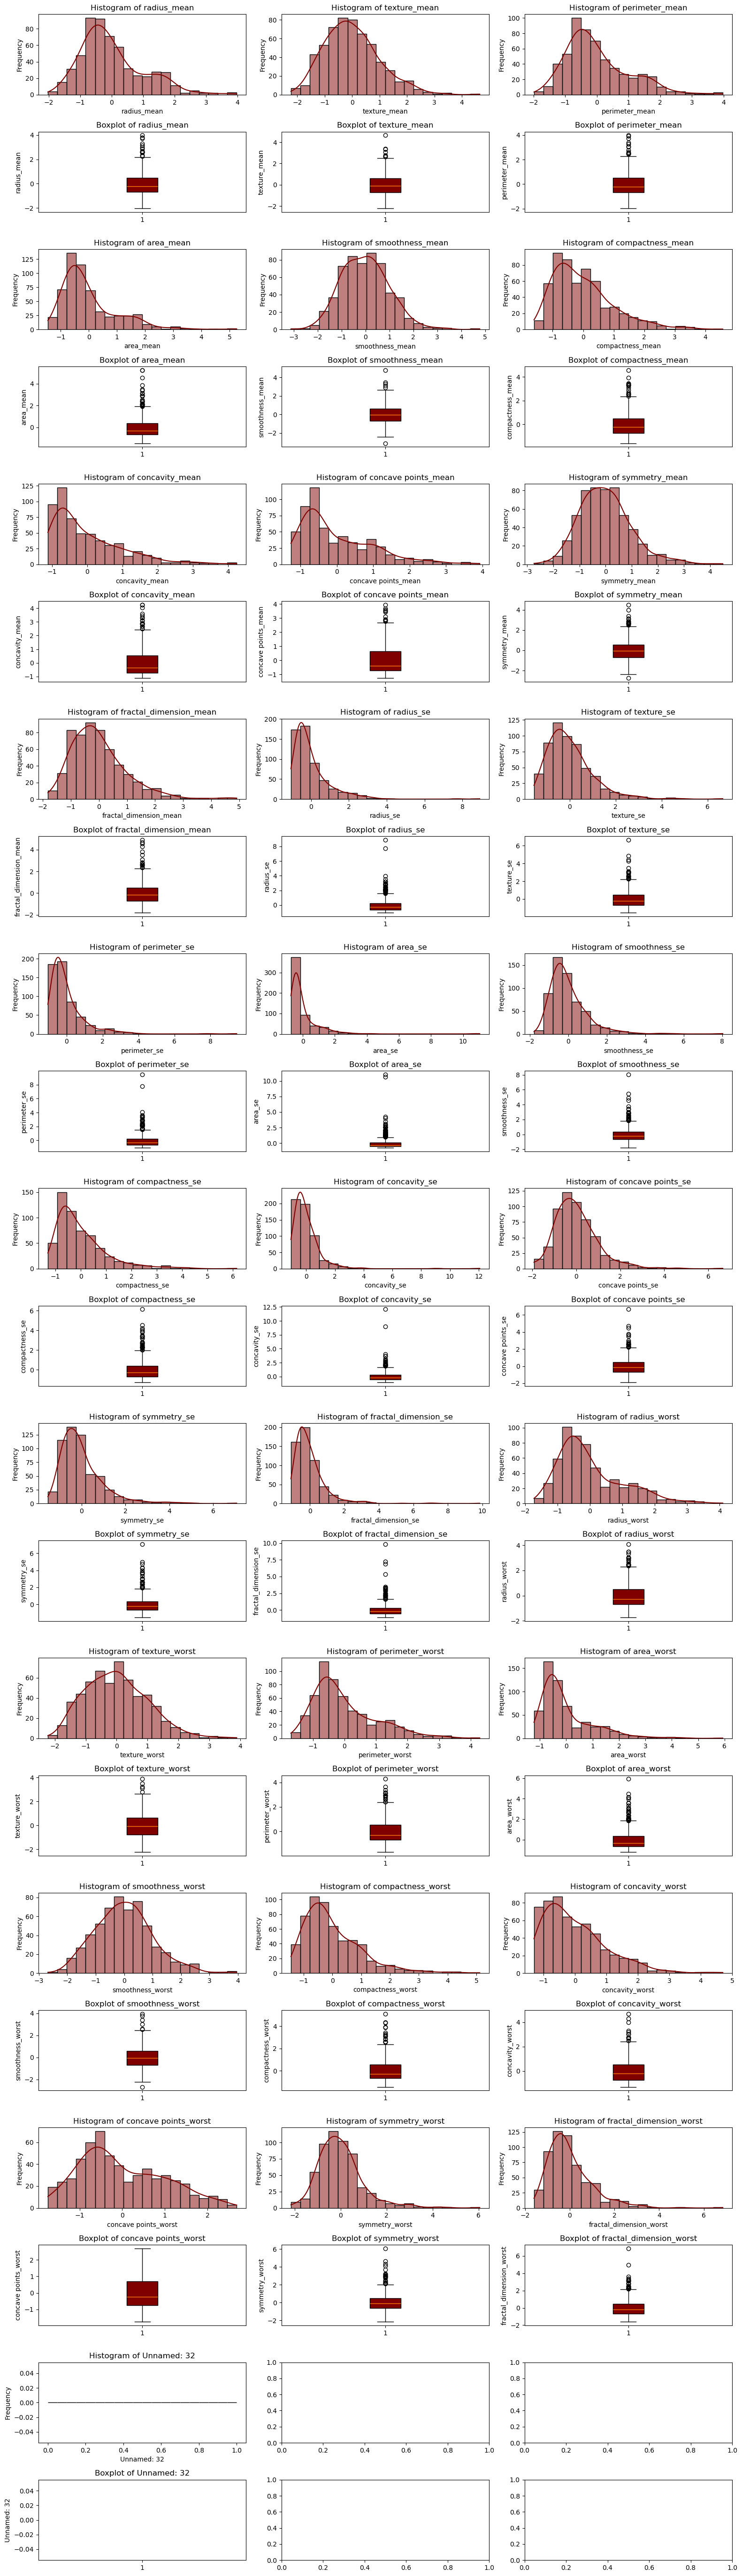

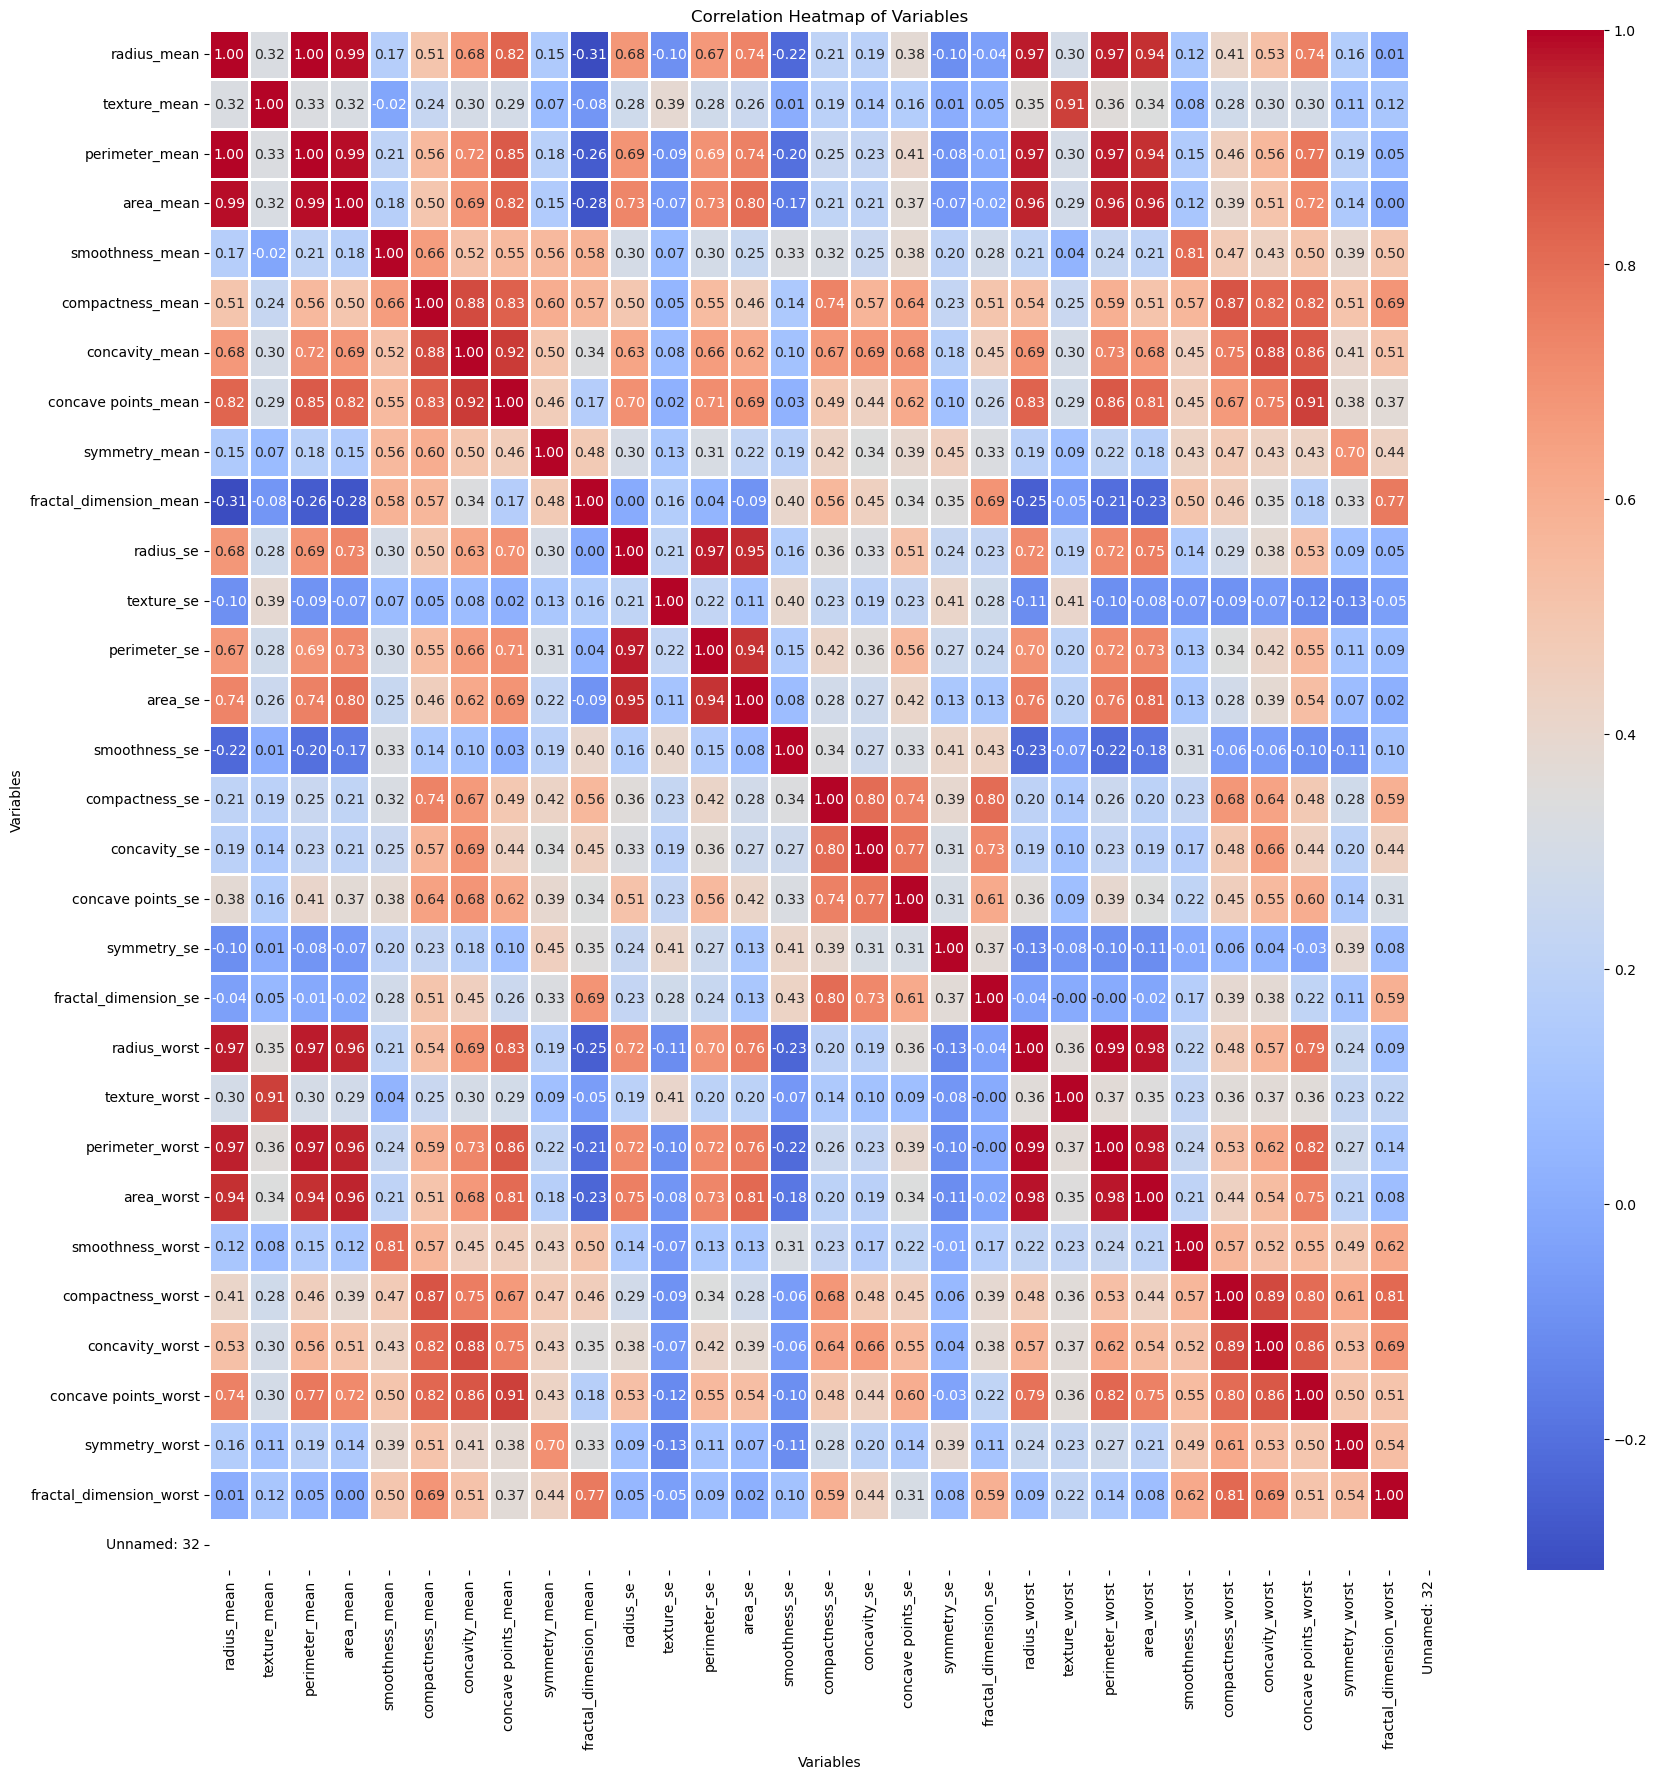

In [63]:
eda(data)

In [69]:
data.drop("Unnamed: 32",inplace=True,axis=1)

In [60]:
data.drop("diagnosis",inplace=True,axis=1)

In [64]:
Columns_to_drop = [
    'radius_mean',
    'texture_mean',
    'perimeter_mean',
    'area_mean',
    'concave points_mean',
    'radius_worst',
    'perimeter_worst',
    'area_worst'
]

# Drop the columns
data.drop(columns=Columns_to_drop, inplace=True)

In [ ]:
#PCA and TSNSE clustering without any metrics

In [70]:
PCA2=data

In [71]:
TSNE2=data

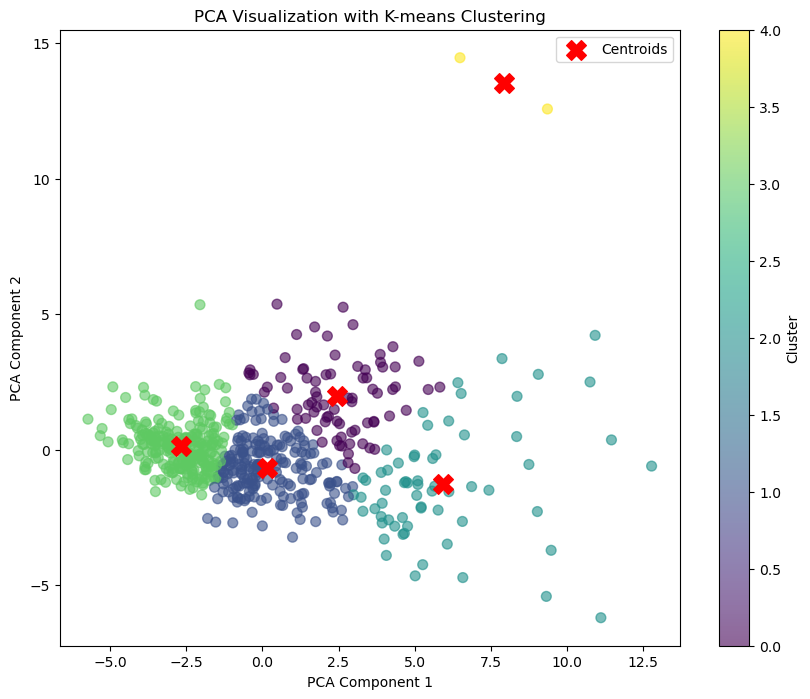

PCA Centroids:
 [[ 2.44762552  1.99172332]
 [ 0.1636327  -0.68171948]
 [ 5.92540994 -1.2774682 ]
 [-2.68651109  0.14048742]
 [ 7.9240744  13.5133693 ]]
PCA Clustering Evaluation Metrics:
 {'Silhouette Score': 0.3945845264258379, 'Inertia': 1713.4547779617178}


In [72]:
pca_data, pca_labels, pca_centroids = PCA_Viz_with_KMeans(PCA2, n_clusters=5)


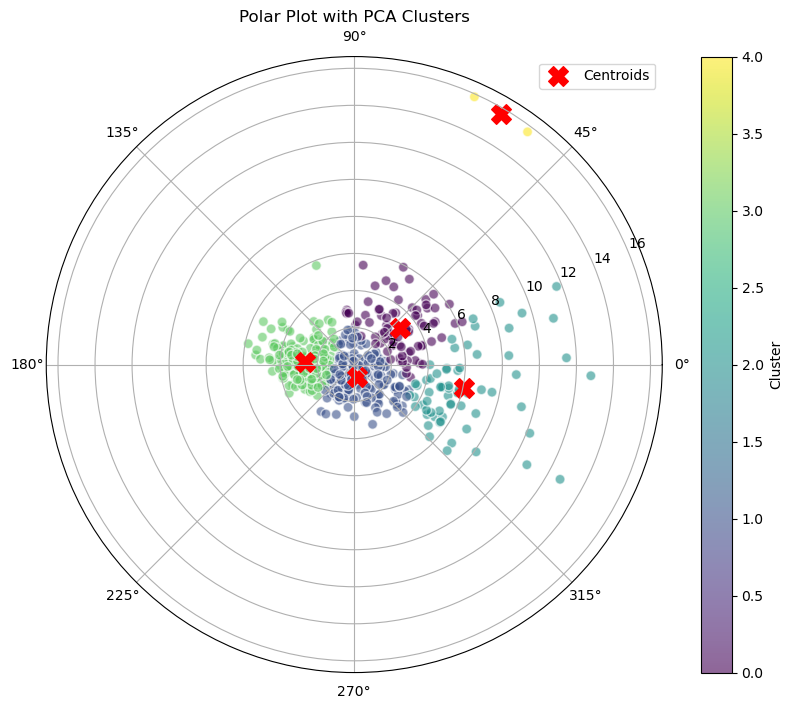

In [75]:
polar_plot(pca_data, pca_labels, pca_centroids, title='Polar Plot with PCA Clusters')

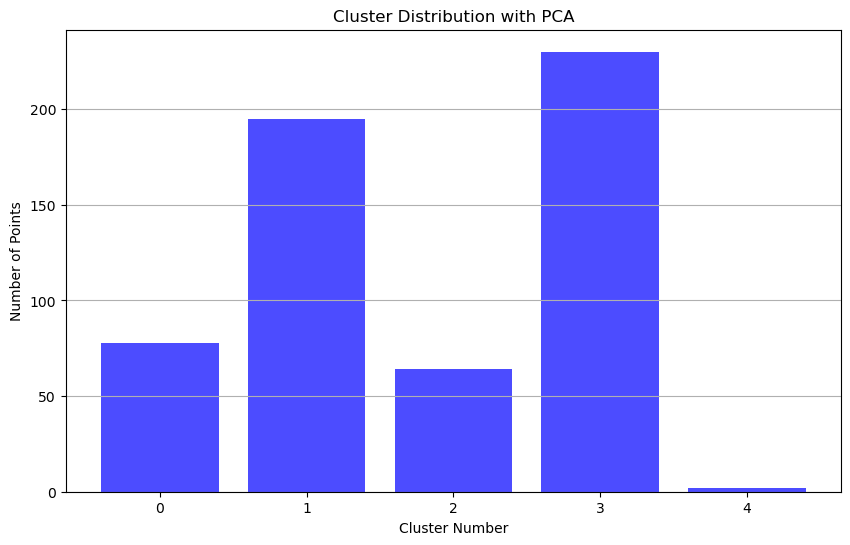

In [78]:
bar_plot_clusters(pca_labels, title='Cluster Distribution with PCA')

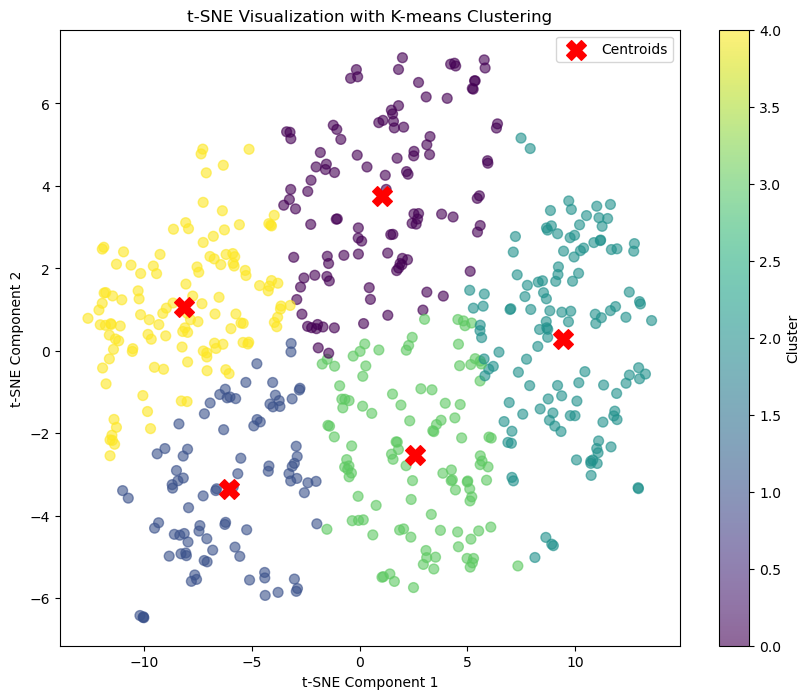

t-SNE Centroids:
 [[ 1.0313087   3.7541811 ]
 [-6.0545683  -3.3400288 ]
 [ 9.438514    0.29131252]
 [ 2.5579078  -2.5270076 ]
 [-8.151006    1.0521276 ]]
t-SNE Clustering Evaluation Metrics:
 {'Silhouette Score': 0.38020286, 'Inertia': 5347.47412109375}


In [79]:
tsne_data, tsne_labels, tsne_centroids = tSNE_Viz_with_KMeans(TSNE2, n_clusters=5)

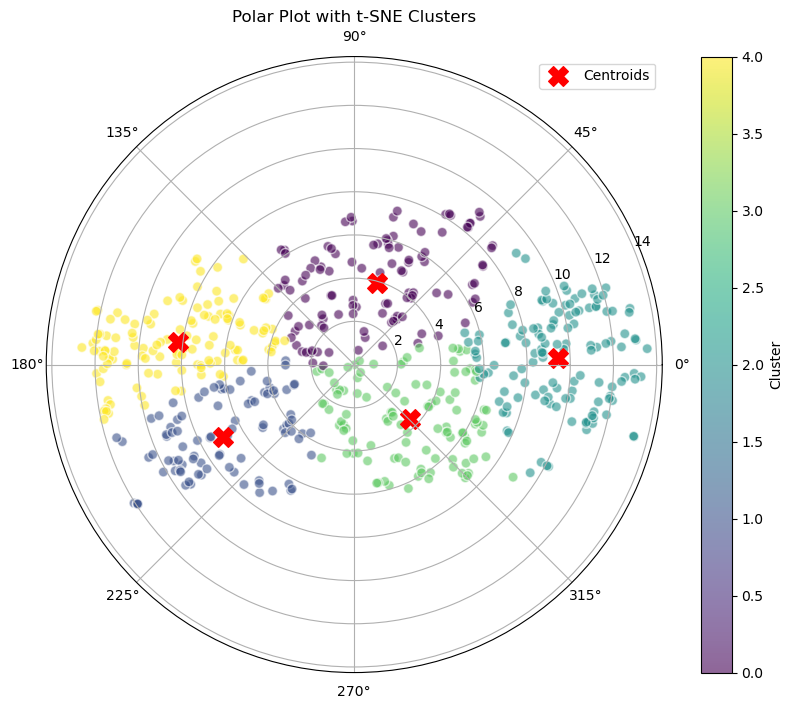

In [80]:
polar_plot(tsne_data, tsne_labels, tsne_centroids, title='Polar Plot with t-SNE Clusters')

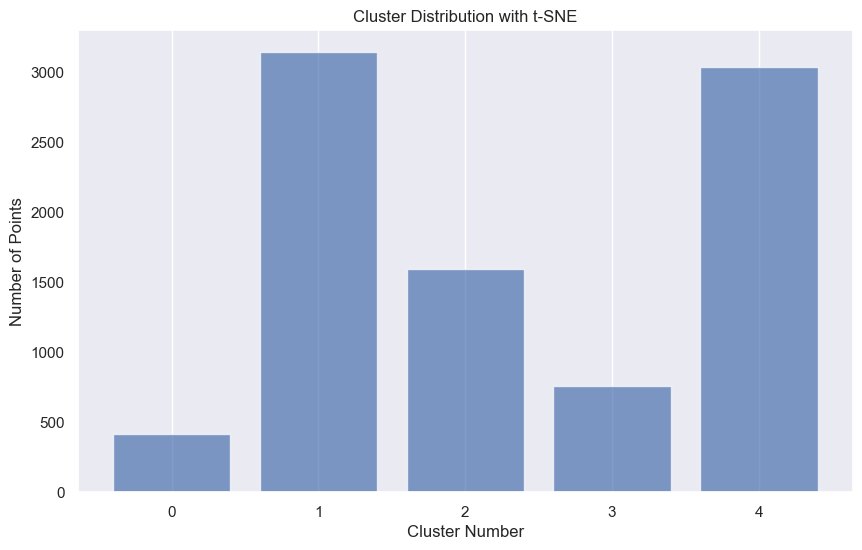

In [124]:
bar_plot_clusters(labels, title='Cluster Distribution with t-SNE')


In [ ]:
#In PCA clusters are properly separated where in TSNE they are. Moreover the as per the above bar graphs the clusters in 1 and 4 are  have most of the data points

In [ ]:
#Calculating Optimum number of clusters through Elbow method

In [81]:
# finding wcss value for different number of clusters
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
    
print(wcss)

[12517.999999999996, 8869.451211792752, 7960.995151808067, 7361.303930437014, 6838.279698167789, 6408.5833618165325, 6209.336570160525, 5873.547861909996, 5713.92133210744, 5404.200927348717]


Text(0.5, 1.0, 'The Elbow Point Graph')

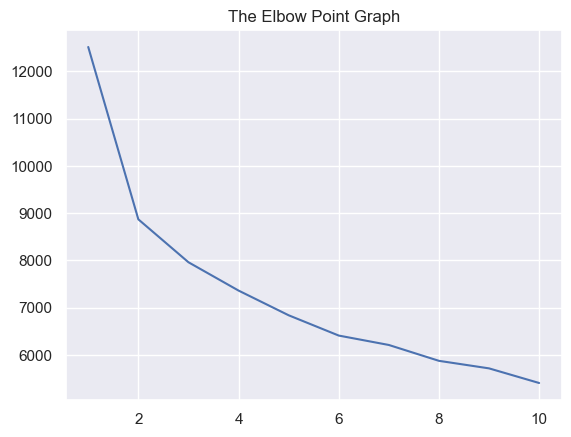

In [82]:
# Plot an elbow graph

sns.set()
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Point Graph')

In [ ]:
#From above interpretations lets now perform cluster analysis with the value of 2

In [83]:
PCA3=data

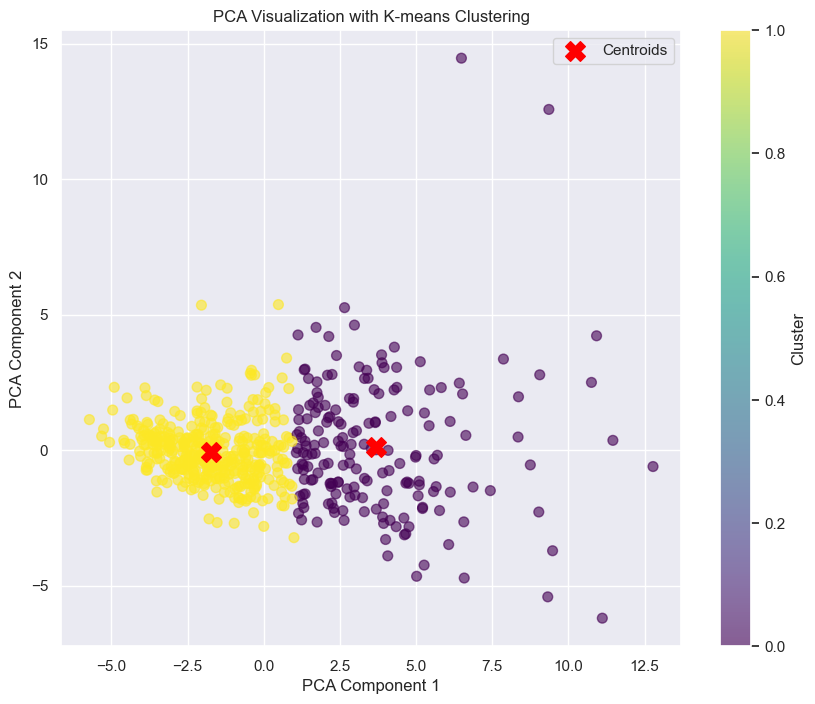

PCA Centroids:
 [[ 3.69705384  0.10713859]
 [-1.72465656 -0.0499796 ]]
PCA Clustering Evaluation Metrics:
 {'Silhouette Score': 0.5079235730696946, 'Inertia': 3461.7827906134153}


In [84]:
pca_data, labels, centroids = PCA_Viz_with_KMeans(PCA3, n_clusters=2)

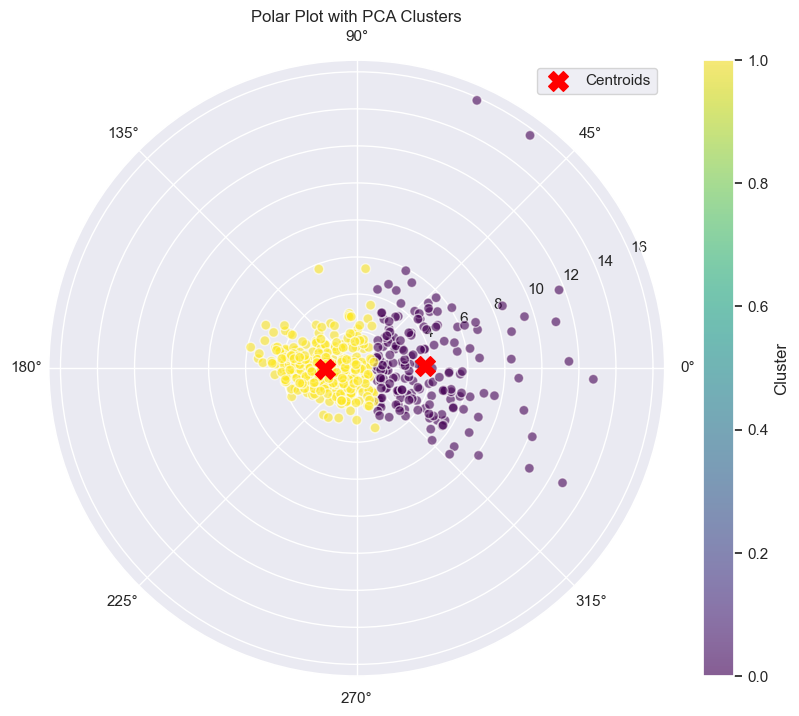

In [85]:
polar_plot(pca_data, labels, centroids, title='Polar Plot with PCA Clusters')

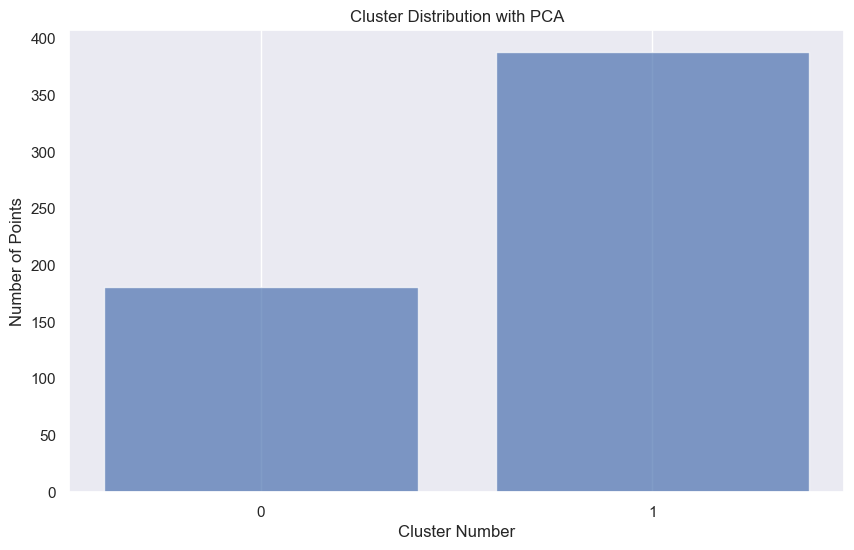

In [86]:
bar_plot_clusters(labels, title='Cluster Distribution with PCA')

In [87]:
TSNE3=data

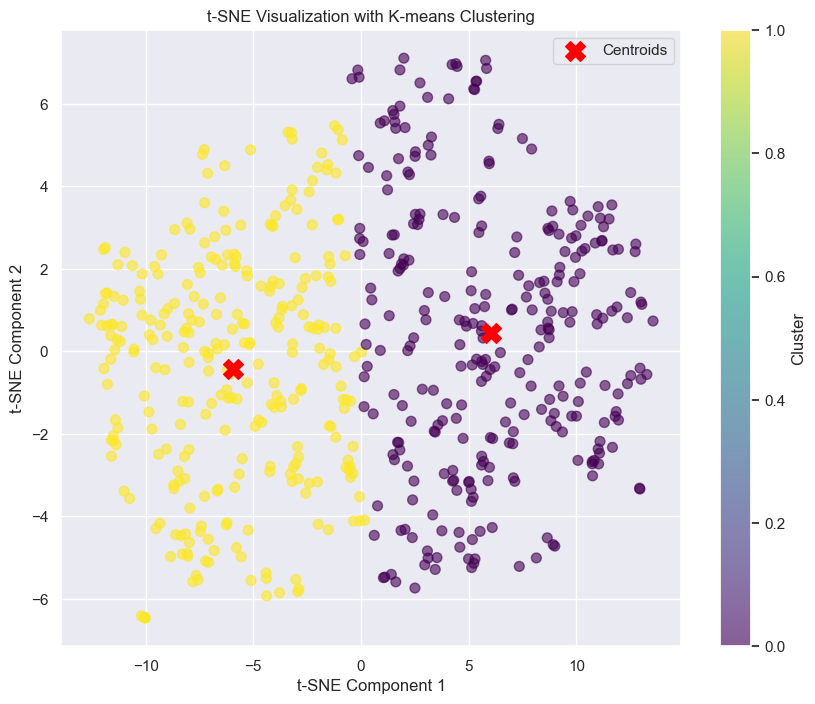

t-SNE Centroids:
 [[ 6.023693    0.4429419 ]
 [-5.9359274  -0.42448455]]
t-SNE Clustering Evaluation Metrics:
 {'Silhouette Score': 0.5026511, 'Inertia': 12524.736328125}


In [88]:
tsne_data, labels, centroids = tSNE_Viz_with_KMeans(TSNE3, n_clusters=2)

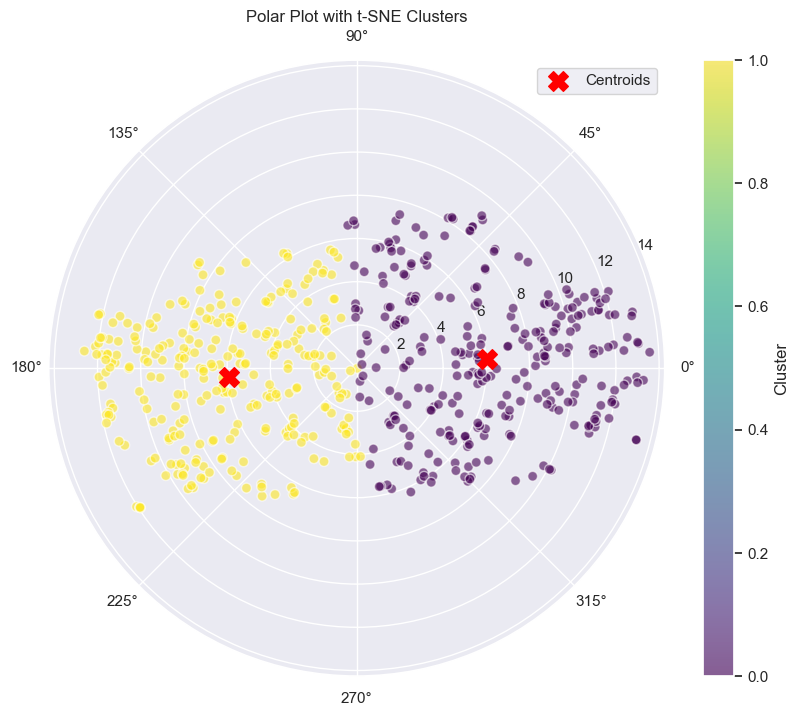

In [89]:
polar_plot(tsne_data, labels, centroids, title='Polar Plot with t-SNE Clusters')


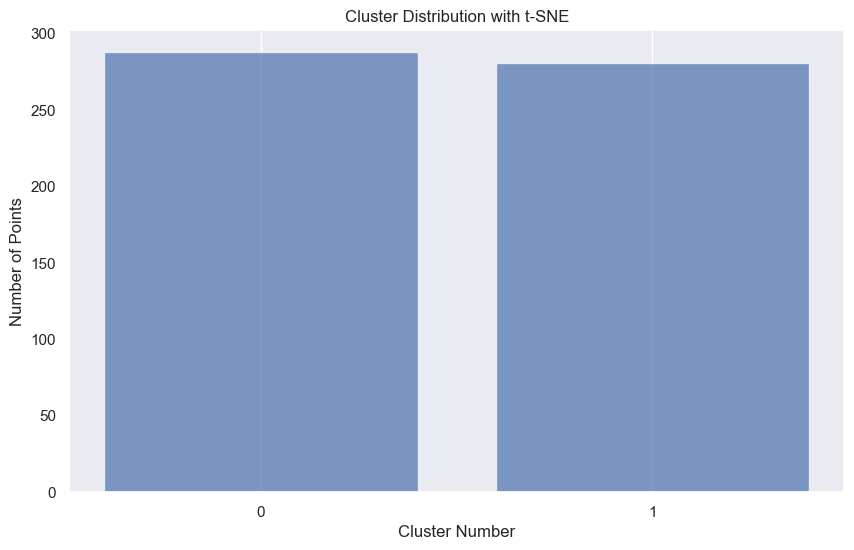

In [90]:
bar_plot_clusters(labels, title='Cluster Distribution with t-SNE')

In [ ]:
#Proper segegration is observed with two clusters, which can lead to the verficication of the business knowledge as per the data classified that the ratio of diagnosis is correct dividing the whole dataset into two class label,s

Cluster Numbers: [2, 3, 4, 5]
Silhouette Scores: [0.32640896114756845, 0.23643717999126815, 0.1597565315160671, 0.1657364387444287]


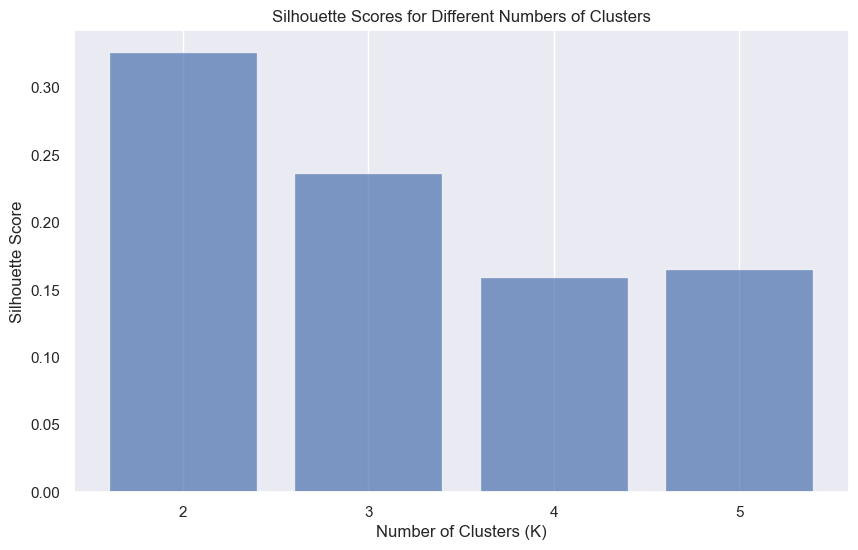

In [93]:
calculate_silhouette_scores(data, [2, 3, 4, 5])

In [ ]:
#As per the above interpretation highest segregation is observed in in the 3 number of clusters. 